In [1]:
from elite_trader.auth import authenticate

authenticate("czl", "Vnpy1234")
from useful_tools import *
import matplotlib.pyplot as plt

In [2]:
from targets_extraction import *
from features_extraction import *

In [34]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.kernel_approximation import Nystroem
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor

In [64]:
df = load_essentials("rb99", "2019-01-01", "2019-1-31", "SHFE")

In [65]:
lags = [10, 20, 30]

In [66]:
def split_features_target(df: pd.DataFrame):
    """split features and target"""
    X = df.drop(
        [
            "pos_change_signal",
            "net_pos_signal",
            "desired_pos_change",
            "desired_pos_rolling",
        ],
        axis=1,
    )
    y = df[
        [
            "pos_change_signal",
            "net_pos_signal",
            "desired_pos_change",
            "desired_pos_rolling",
        ]
    ]

    return X, y

In [67]:
preprocessing_pipeline = make_pipeline(
    FunctionTransformer(prepare_desired_pos, kw_args={"lag": 50, "multiplier": 10}),
    FunctionTransformer(generate_all_features_df, kw_args={"lags": lags}),
    FunctionTransformer(drop_ohlcv_cols),
    FunctionTransformer(split_features_target),
    verbose=True,
)

In [68]:
feature_selection_pipeline = make_pipeline(
    SelectFromModel(ExtraTreesClassifier(n_estimators=100, random_state=42)),
    verbose=True,
)

In [70]:
X = feature_selection_pipeline.fit_transform(X, y["pos_change_signal"])

[Pipeline] ... (step 1 of 1) Processing selectfrommodel, total=   2.1s


In [63]:
X

array([[ 16341.84321287,  32467.72904545,  42638.2432353 , ...,
          3388.91158667,   3389.85187684,   3386.94312345],
       [ 14310.28757625,  31349.838773  ,  42041.90517814, ...,
          3390.23994   ,   3390.13185947,   3388.06296115],
       [ 12955.16854739,  30469.43972126,  41570.02591603, ...,
          3391.15410667,   3390.80928158,   3389.31867701],
       ...,
       [ -2258.92838088, -22756.67749057, -53414.46294167, ...,
          3643.72728667,   3643.36099842,   3642.42406552],
       [ -1947.47025651, -21954.10265452, -52276.5126812 , ...,
          3643.86289333,   3643.34595053,   3642.44966322],
       [ -1538.81540468, -21104.73145405, -51107.78945116, ...,
          3644.14112667,   3643.64243526,   3642.59591586]])

In [69]:
X, y = preprocessing_pipeline.fit_transform(df)

[Pipeline]  (step 1 of 4) Processing functiontransformer-1, total=   0.0s
[Pipeline]  (step 2 of 4) Processing functiontransformer-2, total=   0.1s
[Pipeline]  (step 3 of 4) Processing functiontransformer-3, total=   0.0s
[Pipeline]  (step 4 of 4) Processing functiontransformer-4, total=   0.0s


In [30]:
transformer_pipeline = make_pipeline(
    FunctionTransformer(prepare_desired_pos, kw_args={"lag": 50, "multiplier": 10}),
    FunctionTransformer(generate_all_features_df, kw_args={"lags": [10, 20]}),
    FunctionTransformer(drop_ohlcv_cols),
    verbose=True,
)

In [37]:
transformed_df = transformer_pipeline.transform(df)

In [38]:
model = SelectFromModel(ExtraTreesClassifier(n_estimators=1000, random_state=42))

In [39]:
X = transformed_df.drop(
    [
        "pos_change_signal",
        "net_pos_signal",
        "desired_pos_change",
        "desired_pos_rolling",
    ],
    axis=1,
)
y_pos_change_signal = transformed_df.pos_change_signal

In [44]:
X_transformed = model.fit_transform(X, y_pos_change_signal)

<AxesSubplot:xlabel='datetime'>

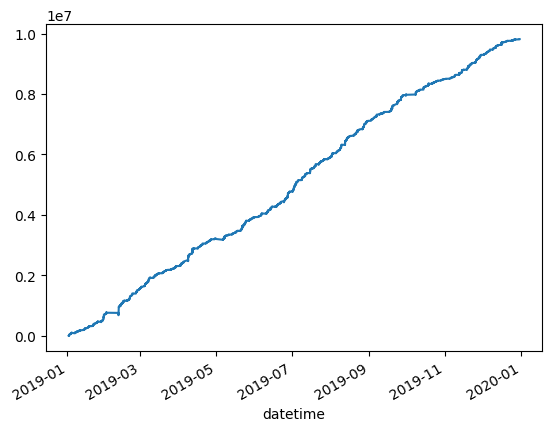

In [5]:
df["balance"] = df.desired_pos_rolling * (df.close - df.open)
df.balance.cumsum().plot()

In [149]:
def prepare_desired_pos(df, lag=50, multiplier=10):
    scaler = StandardScaler()
    df[f"{lag}m_ret"] = scaler.fit_transform(
        log_return(df.close, length=lag, offset=-lag).values.reshape(-1, 1)
    )
    df.dropna(inplace=True)
    df["pos_change"] = df[f"{lag}m_ret"] * multiplier
    df["pos_change"] = df["pos_change"].apply(int)
    df["pos_rolling"] = df["pos_change"].rolling(lag, min_periods=1).sum()
    df.drop(columns=[f"{lag}m_ret"], inplace=True)


def generate_simple_features(df):
    df["open_change"] = df.open.pct_change(50)
    df["high_change"] = df.high.pct_change(50)
    df["low_change"] = df.low.pct_change(50)
    df["close_change"] = df.close.pct_change(50)
    df["volume_change"] = df.volume.pct_change(50)
    df.dropna(inplace=True)

In [145]:
import datetime
import seaborn as sns
import sklearn
from sklearn.ensemble import (
    RandomForestRegressor,
    BaggingRegressor,
    AdaBoostRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeRegressor

In [166]:
random_state = 42
n_jobs = 4
n_estimators = 1000
step_factor = 10
axis_step = int(n_estimators / step_factor)

In [159]:
df = load_essentials("rb99", "2018-01-01", "2019-12-31", "SHFE")
prepare_desired_pos(df)
generate_simple_features(df)
X = df[["open_change", "high_change", "low_change", "close_change", "volume_change"]]
y = df[["pos_change", "pos_rolling"]]

In [160]:
X = scale(remove_infs_and_zeros(X))

c:\Users\tonyc\Documents\GitHub\usefultools\useful_tools.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace([np.inf, -np.inf, np.zeros], 0.0001, inplace=True)


In [164]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state
)

In [167]:
estimators = np.zeros(axis_step)
bagging_mse = np.zeros(axis_step)
rf_mse = np.zeros(axis_step)
boosting_mse = np.zeros(axis_step)

In [170]:
for i in range(0, axis_step):
    print("Bagging Estimator: %d of %d..." % (step_factor * (i + 1), n_estimators))
    bagging = BaggingRegressor(
        DecisionTreeRegressor(),
        n_estimators=step_factor * (i + 1),
        n_jobs=n_jobs,
        random_state=random_state,
    )
    bagging.fit(X_train, y_train)
    mse = mean_squared_error(y_test, bagging.predict(X_test))
    estimators[i] = step_factor * (i + 1)
    bagging_mse[i] = mse

Bagging Estimator: 10 of 1000...
Bagging Estimator: 20 of 1000...
Bagging Estimator: 30 of 1000...
Bagging Estimator: 40 of 1000...
Bagging Estimator: 50 of 1000...
Bagging Estimator: 60 of 1000...
Bagging Estimator: 70 of 1000...
Bagging Estimator: 80 of 1000...
Bagging Estimator: 90 of 1000...
Bagging Estimator: 100 of 1000...
Bagging Estimator: 110 of 1000...
Bagging Estimator: 120 of 1000...
Bagging Estimator: 130 of 1000...
Bagging Estimator: 140 of 1000...
Bagging Estimator: 150 of 1000...
Bagging Estimator: 160 of 1000...
Bagging Estimator: 170 of 1000...
Bagging Estimator: 180 of 1000...
Bagging Estimator: 190 of 1000...
Bagging Estimator: 200 of 1000...
Bagging Estimator: 210 of 1000...
Bagging Estimator: 220 of 1000...
Bagging Estimator: 230 of 1000...
Bagging Estimator: 240 of 1000...
Bagging Estimator: 250 of 1000...
Bagging Estimator: 260 of 1000...
Bagging Estimator: 270 of 1000...
Bagging Estimator: 280 of 1000...
Bagging Estimator: 290 of 1000...
Bagging Estimator: 300 

In [ ]:
for i in range(0, axis_step):
    print(
        "Random Forest Estimator: %d of %d..." % (step_factor * (i + 1), n_estimators)
    )
    rf = RandomForestRegressor(
        n_estimators=step_factor * (i + 1), n_jobs=n_jobs, random_state=random_state
    )
    tf.fit(X_train, y_train)
    mse = mean_squared_srror(y_test, rf.predict(X_test))
    estimators[i] = step_factor * (i + 1)
    rf_mse[i] = mse

In [ ]:
for i in range(0, axis_step):
    print("Boosting Estimator: %d of %d..." %(
        step_factor*(i+1), n_estimators
    ))
    boosting = AdaBoostRegressor(
        DecisionTreeRegressor()
        n_estimators=step_factor*(i+1),
        random_state=random_state,
        learning_rate=0.01
    )
    boosting.fit(X_train, y_train)
    mse = mean_saquared_error(y_test, boosting.predict(X_test))
    estimators[i] = step_factor*(i+1)
    boosing_mse[i] = mse